# Klasifikasi Gambar Makanan Indonesia dengan EfficientNet-B3

Notebook ini menggabungkan fungsionalitas pembacaan data dari `datareader.py` dengan kode pelatihan dari `train_3.py`. Kita akan menggunakan EfficientNet-B3 dengan transfer learning untuk mengklasifikasikan gambar makanan Indonesia.



## Latar Belakang
EfficientNet-B3 adalah arsitektur jaringan saraf yang dioptimalkan untuk klasifikasi gambar. 300 Gecs menggunakan transfer learning dengan bobot pre-trained dari ImageNet untuk memanfaatkan fitur-fitur yang telah dipelajari sebelumnya.

## Environment
venv (python 3.11.9)

## Anggota kelompok
- Muhammad Nelwan Fakhri (122140173)
- Rayhan Fatih Gunawan   (122140134)
- Raditya Erza Farandi   (122140209)

## 1. Import Library yang Dibutuhkan

Pertama, kita akan mengimpor semua library yang diperlukan dan menyiapkan lingkungan. Kita menggunakan:
- PyTorch: Framework deep learning utama
- torchvision: Untuk model EfficientNet dan transformasi gambar
- OpenCV (cv2): Untuk pemrosesan gambar
- tqdm: Untuk pelacakan progres
- scikit-learn: Untuk metrik evaluasi
- matplotlib & seaborn: Untuk visualisasi
- Library pendukung lainnya

Kita juga akan mengatur seed acak untuk memastikan hasil yang dapat direproduksi.

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.transforms import ToTensor, Normalize, Compose
import cv2
import os
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from itertools import cycle

# Set random seed for reproducibility
RANDOM_SEED = 2025
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Utility function for device setup (previously in utils.py)
def check_set_gpu(override=None):
    if override == None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
            print(f"Using MPS: {torch.backends.mps.is_available()}")
        else:
            device = torch.device('cpu')
            print(f"Using CPU: {torch.device('cpu')}")
    else:
        device = torch.device(override)
    return device

# Set device
device = check_set_gpu()  # Using the integrated utility function

Using CPU: cpu


## 2. Implementasi Dataset

Kita akan mengimplementasikan kelas `MakananIndo` yang merupakan turunan dari `torch.utils.data.Dataset`. Kelas ini akan:

- Memuat gambar dari direktori yang ditentukan
- Menangani pembagian data training dan validasi
- Menerapkan transformasi gambar yang diperlukan
- Normalisasi menggunakan statistik ImageNet
- Mengembalikan pasangan gambar-label untuk pelatihan

### Fitur Penting:
1. **Pembagian Data**: 80% training, 20% validasi
2. **Transformasi Default**: 
   - Konversi ke tensor PyTorch
   - Normalisasi menggunakan mean dan std ImageNet
3. **Format Gambar**: 
   - Ukuran diseragamkan ke 300x300 pixel
   - Konversi warna dari BGR ke RGB
   - Normalisasi nilai pixel ke rentang [0,1]

In [15]:
class MakananIndo(Dataset):
    # normalisasi ImageNet
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    def __init__(self,
                 data_dir='IF25-4041-dataset/train',
                 img_size=(300, 300),
                 transform=None,
                 split='train'
                 ):
        
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        self.split = split

        
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.image_files.sort()
        
        # Load label dari CSV
        csv_path = os.path.join(os.path.dirname(data_dir), 'train.csv')
        df = pd.read_csv(csv_path)
        self.label_dict = dict(zip(df['filename'], df['label']))
        self.labels = [self.label_dict.get(f, None) for f in self.image_files]
        
        # split train dan val
        all_data = list(zip(self.image_files, self.labels))
        total_len = len(all_data)
        train_len = int(0.8 * total_len)
        
        indices = list(range(total_len))
        random.shuffle(indices)
        
        if split == 'train':
            self.data = [all_data[i] for i in indices[:train_len]]
        elif split == 'val':
            self.data = [all_data[i] for i in indices[train_len:]]
        else:
            raise ValueError("Split must be 'train' or 'val'")
        
        # Define transform
        self.default_transform = Compose([
            ToTensor(),
            Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data[idx][0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)
        
        label = self.data[idx][1]
        
        return image, label, img_path

# fungsi label encoding
def create_label_encoder(dataset):
    """Create a mapping from string labels to numeric indices"""
    all_labels = []
    for i in range(len(dataset)):
        _, label, _ = dataset[i]
        all_labels.append(label)
    
    unique_labels = sorted(list(set(all_labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for idx, label in enumerate(unique_labels)}
    
    return label_to_idx, idx_to_label, unique_labels

## 3. Fungsi-fungsi Pelatihan

### Fungsi train_one_epoch:
- Melatih model untuk satu epoch
- Menghitung loss dan akurasi training
- Melakukan optimisasi parameter model
- Menampilkan progress bar dengan metrik real-time

### Fungsi validate:
- Mengevaluasi model pada data validasi
- Menghitung loss dan akurasi validasi
- Tidak melakukan backpropagation
- Menampilkan progress bar dengan metrik

### Fitur Umum:
- Konversi label string ke indeks numerik
- Penggunaan tqdm untuk visualisasi progres
- Penanganan batch processing yang efisien
- Perhitungan metrik secara real-time

In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, label_to_idx):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
        inputs = inputs.to(device)
        
        # mengubah label string ke indeks numerik
        if isinstance(labels_tuple, (tuple, list)):
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[label] for label in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long).to(device)
        else:
            targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'loss': total_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })
    
    return total_loss/len(dataloader), 100.*correct/total

def validate(model, dataloader, criterion, device, label_to_idx):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
            inputs = inputs.to(device)
            
          
            if isinstance(labels_tuple, (tuple, list)):
                if isinstance(labels_tuple[0], str):
                    label_indices = [label_to_idx[label] for label in labels_tuple]
                else:
                    label_indices = labels_tuple
                targets = torch.tensor(label_indices, dtype=torch.long).to(device)
            else:
                targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': total_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
    
    return total_loss/len(dataloader), 100.*correct/total

## 4. Persiapan Dataset dan DataLoader

1. **Menyiapkan Hyperparameter**:
   - Jumlah epoch: 30
   - Ukuran batch: 32
   - Learning rate: 0.01
   - Ukuran gambar: 300x300

2. **Membuat Dataset**:
   - Dataset training dengan augmentasi
   - Dataset validasi untuk evaluasi

3. **Pengkodean Label**:
   - Konversi label string ke indeks numerik
   - Membuat mapping dua arah (indeks ↔ label)

4. **Konfigurasi DataLoader**:
   - Mengatur jumlah worker untuk loading parallel
   - Mengaktifkan shuffling untuk data training
   - Mengoptimalkan memory dengan pin_memory

In [17]:
# Hyperparameter
num_epochs = 30
batch_size = 32
learning_rate = 0.01
img_size = (300, 300)  # EfficientNet-B3 input size


print("Loading datasets...")
train_dataset = MakananIndo(
    data_dir='IF25-4041-dataset/train',
    img_size=img_size,
    split='train'
)

val_dataset = MakananIndo(
    data_dir='IF25-4041-dataset/train',
    img_size=img_size,
    split='val'
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# label encoder
print("\nCreating label encoder...")
label_to_idx, idx_to_label, unique_labels = create_label_encoder(train_dataset)
num_classes = len(unique_labels)

print(f"Number of classes: {num_classes}")
print(f"Classes: {unique_labels}")
print(f"Label to index mapping: {label_to_idx}")

# data loader
cpu_count = os.cpu_count()
nworkers = cpu_count - 4 if cpu_count > 4 else 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=nworkers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=nworkers,
    pin_memory=True
)

Loading datasets...
Train dataset size: 866
Validation dataset size: 217

Creating label encoder...
Number of classes: 5
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Label to index mapping: {'bakso': 0, 'gado_gado': 1, 'nasi_goreng': 2, 'rendang': 3, 'soto_ayam': 4}
Number of classes: 5
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Label to index mapping: {'bakso': 0, 'gado_gado': 1, 'nasi_goreng': 2, 'rendang': 3, 'soto_ayam': 4}


## Debug Pemuatan Dataset

Mari kita uji pemuatan dataset dengan satu worker untuk mengisolasi masalah potensial:
- Memuat beberapa sampel dari dataset
- Memeriksa bentuk tensor dan label
- Memastikan path gambar valid

In [18]:
# test beberapa sample dari dataset
print("Testing dataset loading...")
try:
    for i in range(min(5, len(train_dataset))):
        image, label, path = train_dataset[i]
        print(f"Successfully loaded image {i+1}:")
        print(f"- Shape: {image.shape}")
        print(f"- Label: {label}")
        print(f"- Path: {path}")
        print("-" * 50)
except Exception as e:
    print(f"Error loading sample {i}: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise

Testing dataset loading...
Successfully loaded image 1:
- Shape: torch.Size([3, 300, 300])
- Label: gado_gado
- Path: IF25-4041-dataset/train\0088.jpg
--------------------------------------------------
Successfully loaded image 2:
- Shape: torch.Size([3, 300, 300])
- Label: bakso
- Path: IF25-4041-dataset/train\0203.jpg
--------------------------------------------------
Successfully loaded image 3:
- Shape: torch.Size([3, 300, 300])
- Label: bakso
- Path: IF25-4041-dataset/train\0629.jpg
--------------------------------------------------
Successfully loaded image 4:
- Shape: torch.Size([3, 300, 300])
- Label: nasi_goreng
- Path: IF25-4041-dataset/train\0693.jpg
--------------------------------------------------
Successfully loaded image 5:
- Shape: torch.Size([3, 300, 300])
- Label: nasi_goreng
- Path: IF25-4041-dataset/train\0889.jpg
--------------------------------------------------


In [19]:

print("Creating data loaders with conservative settings...")

# minimal workers dan no pin_memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  #
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  
    pin_memory=False
)

# Tes batch loading
print("\nTesting batch loading...")
try:
    # tes satu batch dari loader
    sample_batch = next(iter(train_loader))
    images, labels, paths = sample_batch
    print(f"Successfully loaded a batch:")
    print(f"- Batch image shape: {images.shape}")
    print(f"- Batch labels: {labels}")
    print("\nDataLoader configuration successful!")
except Exception as e:
    print(f"Error loading batch: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise

Creating data loaders with conservative settings...

Testing batch loading...
Successfully loaded a batch:
- Batch image shape: torch.Size([32, 3, 300, 300])
- Batch labels: ('bakso', 'nasi_goreng', 'gado_gado', 'nasi_goreng', 'bakso', 'soto_ayam', 'nasi_goreng', 'soto_ayam', 'gado_gado', 'bakso', 'rendang', 'rendang', 'bakso', 'soto_ayam', 'bakso', 'rendang', 'bakso', 'gado_gado', 'soto_ayam', 'rendang', 'bakso', 'soto_ayam', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam', 'nasi_goreng', 'gado_gado', 'nasi_goreng', 'soto_ayam', 'soto_ayam', 'gado_gado')

DataLoader configuration successful!
Successfully loaded a batch:
- Batch image shape: torch.Size([32, 3, 300, 300])
- Batch labels: ('bakso', 'nasi_goreng', 'gado_gado', 'nasi_goreng', 'bakso', 'soto_ayam', 'nasi_goreng', 'soto_ayam', 'gado_gado', 'bakso', 'rendang', 'rendang', 'bakso', 'soto_ayam', 'bakso', 'rendang', 'bakso', 'gado_gado', 'soto_ayam', 'rendang', 'bakso', 'soto_ayam', 'gado_gado', 'nasi_goreng', 'rendang', 'soto

## 5. Memuat Model yang Telah Dilatih

Pada bagian ini, kita akan memuat model EfficientNet-B3 yang telah dilatih dari file `best_model.pth`. Model ini telah dilatih sebelumnya pada dataset makanan Indonesia kami dan mencapai akurasi validasi terbaik selama pelatihan.

### Arsitektur Model
Model menggunakan arsitektur berikut:
1. **Model Dasar**: EfficientNet-B3 pre-trained dari ImageNet
2. **Classifier Kustom**:
   - Fitur input: 1536 (dimensi fitur EfficientNet-B3)
   - Layer tersembunyi: 512 unit dengan aktivasi ReLU
   - Layer dropout (0.3 dan 0.2) untuk regularisasi
   - Layer output: Jumlah kelas makanan

### Proses Pemuatan:
1. Inisialisasi arsitektur model
2. Memuat state dictionary yang tersimpan
3. Memindahkan model ke perangkat yang sesuai (GPU/CPU)
4. Mengatur model ke mode evaluasi

Model yang tersimpan berisi:
- State dictionary model (bobot dan bias)
- Metadata pelatihan (epoch, akurasi terbaik)
- State optimizer (jika diperlukan untuk melanjutkan pelatihan)

In [20]:
# load pre-trained model
print("Loading pre-trained EfficientNet-B3 model...")
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)

# Modifikasi classifier disamakan dengan midel yang disimpen model architecture
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(1536, 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, num_classes)
)

# Load  saved model state
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
best_val_acc = checkpoint['best_val_acc']


model = model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Best validation accuracy from training: {best_val_acc:.2f}%")
print(f"Model is using device: {device}")
print("-" * 50)

Loading pre-trained EfficientNet-B3 model...
Model loaded successfully!
Best validation accuracy from training: 99.54%
Model is using device: cpu
--------------------------------------------------
Model loaded successfully!
Best validation accuracy from training: 99.54%
Model is using device: cpu
--------------------------------------------------


### Ringkasan Arsitektur Model

Berikut adalah ringkasan detail dari arsitektur model, termasuk:
- Jumlah parameter per layer
- Ukuran output di setiap layer
- Total parameter (trainable dan non-trainable)
- Penggunaan memori
- Alur forward pass

In [ ]:
# Tampilkan ringkasan model menggunakan torchinfo
from torchinfo import summary

# Definisikan ukuran input yang sesuai dengan dataset
input_size = (batch_size, 3, 300, 300)

# Tampilkan ringkasan model dengan detail
model_summary = summary(model, 
                      input_size=input_size,
                      col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                      col_width=20,
                      row_settings=["var_names"])

# Tampilkan statistik penggunaan parameter
print("\nStatistik Parameter Model:")
print(f"Total Parameters: {model_summary.total_params:,}")
print(f"Trainable Parameters: {model_summary.trainable_params:,}")
print(f"Non-trainable Parameters: {model_summary.total_params - model_summary.trainable_params:,}")
print(f"Estimasi Ukuran Model: {model_summary.total_params * 4 / (1024*1024):.2f} MB")

## 6. Evaluasi Model

Sekarang kita akan mengevaluasi performa model dengan berbagai metrik:

### Metrik yang Digunakan:
1. **Confusion Matrix**: 
   - Visualisasi prediksi vs label sebenarnya
   - Menunjukkan kesalahan klasifikasi antar kelas
   - Membantu identifikasi kelas yang sering tertukar

2. **Classification Report**:
   - Precision: Ketepatan prediksi positif
   - Recall: Kemampuan mengenali sampel positif
   - F1-score: Rata-rata harmonik precision dan recall
   - Support: Jumlah sampel per kelas

3. **Kurva ROC dan Nilai AUC**:
   - Menunjukkan trade-off sensitivitas vs spesifisitas
   - AUC = 1.0 berarti klasifikasi sempurna
   - AUC = 0.5 berarti klasifikasi acak

## Memahami Kinerja Model

Setelah memuat model yang telah dilatih, mari kita analisis kinerjanya menggunakan berbagai metrik. Evaluasi komprehensif ini akan membantu kita memahami seberapa baik model mengklasifikasikan berbagai jenis makanan Indonesia.

### Mengapa Menggunakan Beberapa Metrik?
Metrik yang berbeda memberikan wawasan yang berbeda tentang kinerja model:

1. **Matriks Kebingungan (Confusion Matrix)**: 
   - Menunjukkan gambaran lengkap prediksi model vs label sebenarnya
   - Membantu mengidentifikasi kelas yang sering tertukar
   - Penting untuk memahami kesalahan sistematis

2. **Metrik per Kelas**:
   - **Presisi**: Seberapa akurat prediksi positif?
     - Presisi tinggi → Sedikit false positive
     - Penting ketika false positive berisiko tinggi
   - **Recall**: Seberapa baik model menemukan kasus positif?
     - Recall tinggi → Sedikit false negative
     - Penting ketika melewatkan kasus positif berisiko tinggi
   - **F1-Score**: Rata-rata harmonik presisi dan recall
     - Metrik seimbang untuk kelas yang tidak seimbang
     - Baik untuk penilaian kinerja keseluruhan

3. **Kurva ROC dan AUC**:
   - Menunjukkan kemampuan model membedakan antar kelas
   - AUC = 1.0: Klasifikasi sempurna
   - AUC = 0.5: Tebakan acak
   - Membantu membandingkan kinerja pada berbagai threshold

### Analisis Visual
Kita juga akan memvisualisasikan beberapa prediksi untuk:
- Melihat contoh klasifikasi yang benar dan salah
- Memahami jenis gambar yang menantang
- Mengidentifikasi pola dalam kesalahan klasifikasi

Getting model predictions...


Evaluating: 100%|██████████| 7/7 [00:27<00:00,  3.92s/it]



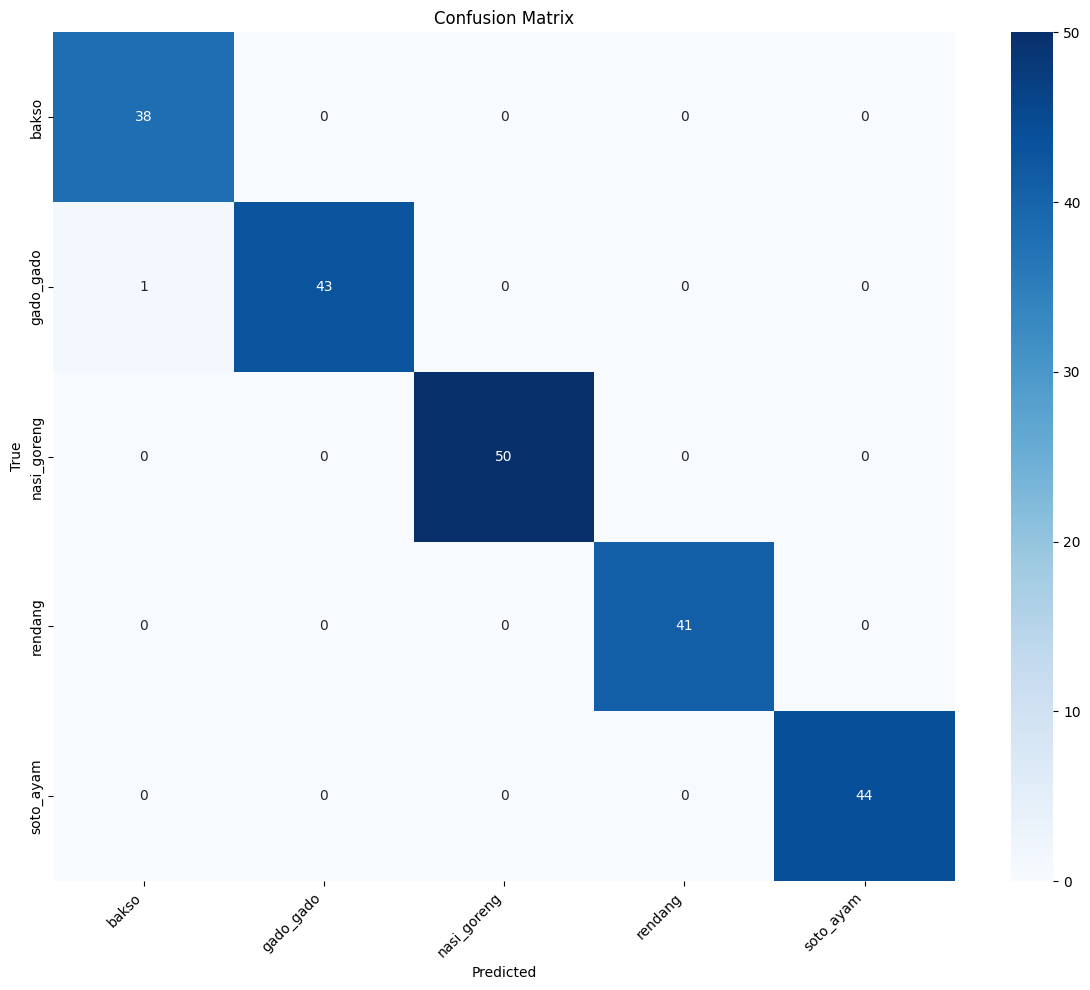


Classification Report:
              precision    recall  f1-score   support

       bakso       0.97      1.00      0.99        38
   gado_gado       1.00      0.98      0.99        44
 nasi_goreng       1.00      1.00      1.00        50
     rendang       1.00      1.00      1.00        41
   soto_ayam       1.00      1.00      1.00        44

    accuracy                           1.00       217
   macro avg       0.99      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



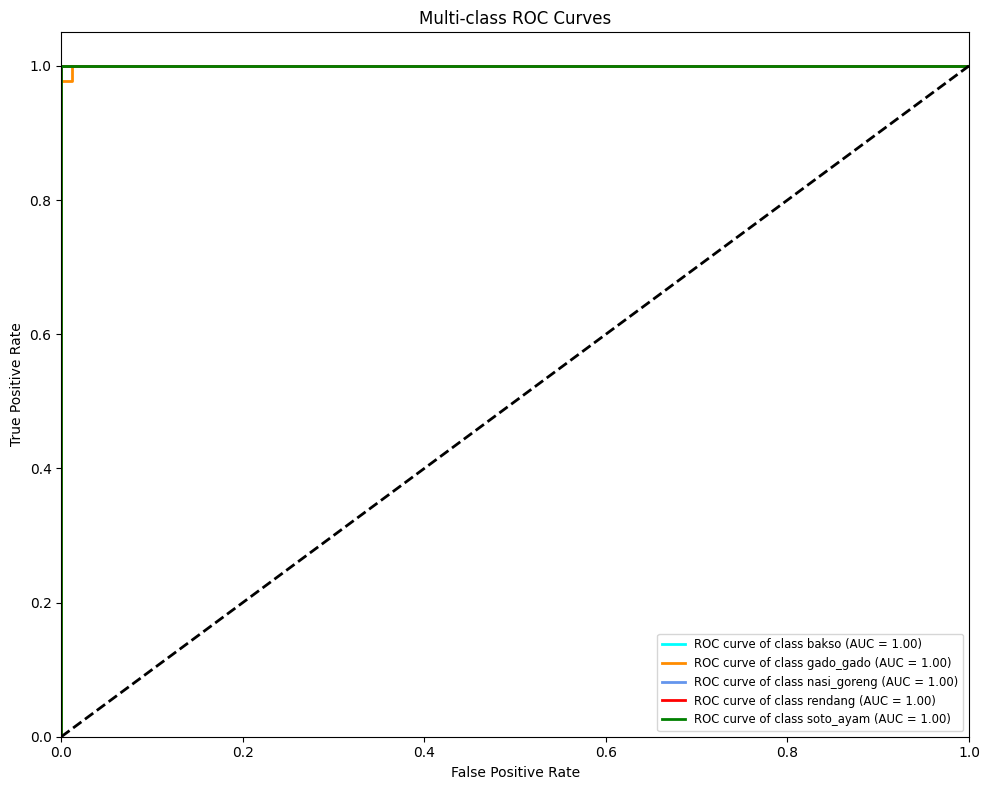

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from itertools import cycle

def evaluate_model(model, dataloader, device, label_to_idx, idx_to_label):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels_tuple, _ in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
         
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[label] for label in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


print("Getting model predictions...")
val_preds, val_labels, val_probs = evaluate_model(model, val_loader, device, label_to_idx, idx_to_label)

# confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(len(idx_to_label))],
            yticklabels=[idx_to_label[i] for i in range(len(idx_to_label))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds,
                          target_names=[idx_to_label[i] for i in range(len(idx_to_label))]))

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])

for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = roc_curve((val_labels == i).astype(int), val_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {idx_to_label[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

### Analisis Hasil

Mari kita pahami arti dari setiap metrik evaluasi:

1. **Matriks Kebingungan (Confusion Matrix)**
   - Elemen diagonal: Jumlah prediksi yang benar
   - Elemen non-diagonal: Kesalahan klasifikasi
   - Warna lebih gelap menunjukkan jumlah yang lebih besar
   - Membantu identifikasi pola kesalahan prediksi

2. **Laporan Klasifikasi (Classification Report)**
   - Presisi: Seberapa akurat prediksi positif
   - Recall: Seberapa baik model menemukan kasus positif
   - F1-score: Keseimbangan antara presisi dan recall
   - Support: Jumlah sampel dalam dataset

3. **Kurva ROC dan Nilai AUC**
   - True Positive Rate: Kemampuan mendeteksi kasus positif
   - False Positive Rate: Tingkat kesalahan positif
   - AUC mendekati 1.0: Model sangat baik
   - AUC mendekati 0.5: Model seperti menebak acak

4. **Visualisasi Prediksi**
   - Gambar dengan label hijau: Prediksi benar
   - Gambar dengan label merah: Prediksi salah
   - Membantu memahami jenis kesalahan visual yang dibuat model

Visualizing some predictions...


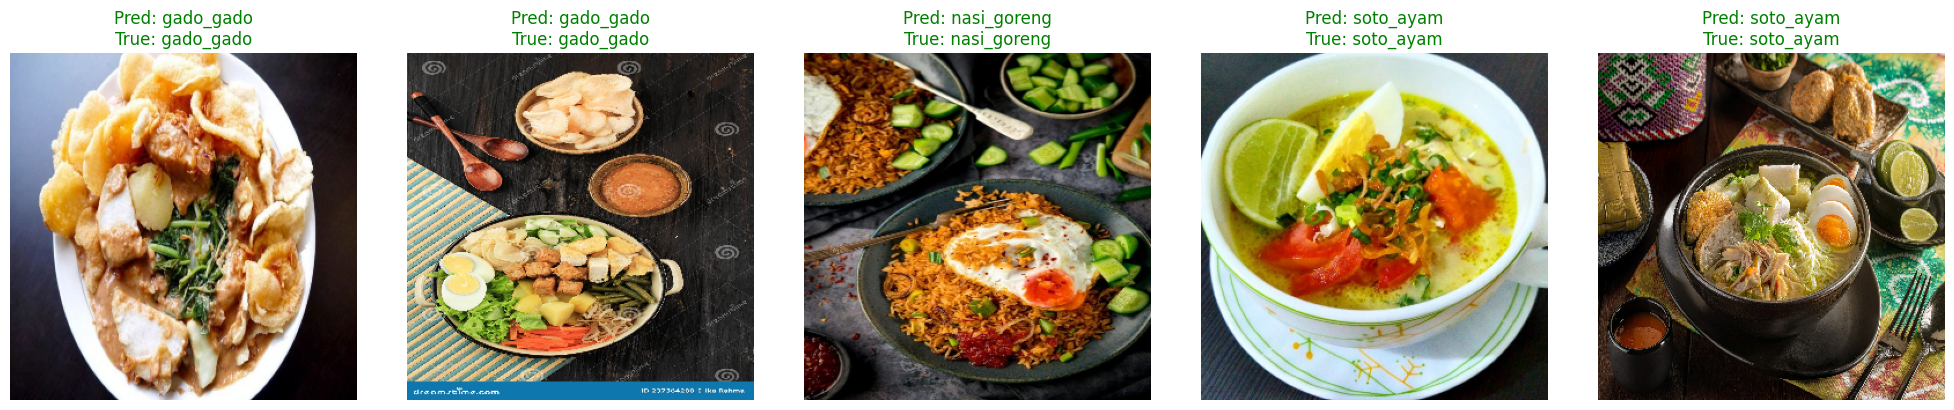

In [22]:
# Visualisasi prediksi
def show_predictions(model, dataloader, device, num_images=5):
    model.eval()
    all_images = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            if len(all_images) >= num_images:
                break
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Convert tensors ke numpy untuk visualization
            images = inputs.cpu().numpy()
            preds = preds.cpu().numpy()
            
            all_images.extend(images)
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Plot images dengan prediksi
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, (img, pred, true_label) in enumerate(zip(all_images[:num_images], 
                                                   all_preds[:num_images], 
                                                   all_labels[:num_images])):
        # Convert dari CHW ke HWC format lalu denormalize
        img = img.transpose(1, 2, 0)
        img = img * np.array(MakananIndo.IMAGENET_STD) + np.array(MakananIndo.IMAGENET_MEAN)
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        color = 'green' if idx_to_label[pred] == true_label else 'red'
        axes[i].set_title(f'Pred: {idx_to_label[pred]}\nTrue: {true_label}', 
                         color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show some example predictions
print("Visualizing some predictions...")
show_predictions(model, val_loader, device)

## 7. Memprediksi Data Uji

Sekarang kita akan menggunakan model yang telah dilatih untuk:
1. Membaca file test.csv
2. Memuat dan memproses gambar uji
3. Membuat prediksi menggunakan model kita
4. Menyimpan prediksi dalam format jawaban.csv

Proses ini akan mengikuti langkah-langkah berikut:
1. Membuat kelas TestDataset untuk menangani data uji
2. Memuat dan memproses gambar uji menggunakan transformasi yang sama
3. Menjalankan inferensi pada dataset uji
4. Memformat dan menyimpan prediksi dalam format yang diperlukan

In [ ]:
# buat TestDataset class
class TestDataset(Dataset):
    def __init__(self, data_dir, csv_path, img_size=(300, 300)):
        self.data_dir = data_dir
        self.img_size = img_size
        
        # Load test.csv
        self.df = pd.read_csv(csv_path)
        self.image_files = self.df['filename'].values
        
      
        self.transform = Compose([
            ToTensor(),
            Normalize(mean=MakananIndo.IMAGENET_MEAN, std=MakananIndo.IMAGENET_STD)
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        image = self.transform(image)
        
        return image, img_name


print("Loading test dataset...")
test_dataset = TestDataset(
    data_dir='IF25-4041-dataset/test', 
    csv_path='IF25-4041-dataset/test.csv'
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"Number of test images: {len(test_dataset)}")

NameError: name 'r' is not defined

In [ ]:
# Buat prediksi dengan dataset test
print("Making predictions on test dataset...")
model.eval()
predictions = []
filenames = []

with torch.no_grad():
    for images, image_names in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        pred_labels = [idx_to_label[idx.item()] for idx in preds]
        
        predictions.extend(pred_labels)
        filenames.extend(image_names)

results_df = pd.DataFrame({
    'filename': filenames,
    'label': predictions
})

# Simpan predictions ke jawaban.csv
output_path = 'IF25-4041-dataset/jawaban.csv'
results_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to {output_path}")

# Display beberapa prediksi pertama
print("\nFirst few predictions:")
print(results_df.head())

plt.figure(figsize=(15, 6))
results_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Predicted Classes in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()